Measured α(23) = 0.29724994021819884 ppm/°C
Measured β = 0.0027718294717260505 ppm/°C²
𐤃Nominal at 23°C = 15.346942543104092 ppm perhaps
Test current 100uA (Fluke 8508A)
Target °C per hour = 0.07


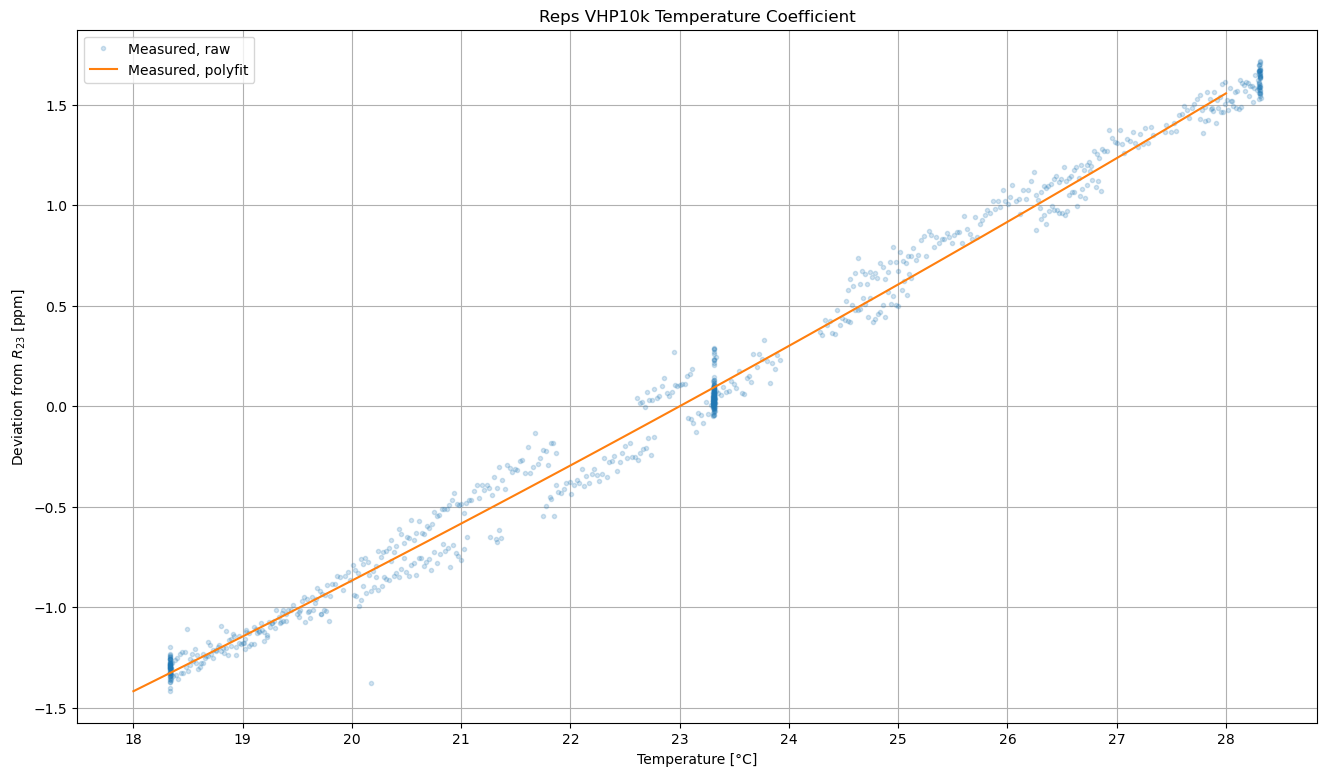

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev

df=pd.read_csv('https://raw.githubusercontent.com/marcoreps/resistors/refs/heads/main/csv/742a_10k_another_TCR_sweep_18_23_all_raw.csv', names=['Time', 'temp_ambient', 'temp_chamber', 'F742A_DUT', 'SR104_ambient', 'SR104_thermistor', '742_casing_pt100', 'VHP10k_DUT'], skiprows=1)

# We have one data point per time row, lets merge these into one row every 20m
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df = df.resample('20min').mean()
df = df.dropna(how='any')

# Lets look only at points where ambient temp is good
temp_threshold = 1
temp_mask = (df['temp_ambient'] >= (23.00 - temp_threshold)) & \
            (df['temp_ambient'] <= (23.00 + temp_threshold))
filtered_df = df[temp_mask].copy()

# Correcting DMM measurements based on SR104_ambient and SR104_thermistor
SR104_best_guess = 1.00000500E+04
SR104_alpha = -0.04240
SR104_beta = -0.02552
filtered_df['dmm_correction_factor'] = ((SR104_best_guess*(   1.0+(SR104_alpha/1000000.0)*((filtered_df['SR104_thermistor']-10000.0)/10.0) + (SR104_beta/1000000.0)*((filtered_df['SR104_thermistor']-10000.0)/10.0)**2.0 ))/ filtered_df['SR104_ambient'])
filtered_df['corrected_VHP10k_DUT']=filtered_df['VHP10k_DUT']*filtered_df['dmm_correction_factor']

# Polyfit
polyfunction = Chebyshev.fit(filtered_df['742_casing_pt100'], filtered_df['corrected_VHP10k_DUT'], deg=2)

# Prepare the plot
fig,ax = plt.subplots(figsize=(16,9))
plt.xlabel('Temperature [°C]')
plt.ylabel(r'Deviation from $R_{23}$ [ppm]')
ax.set_xticks(np.arange(18, 28.1, 1))
plt.grid(True, which="both")
plt.title('Reps VHP10k Temperature Coefficient')
xpoints = np.linspace(18, 28, 100)
r23 = polyfunction(23)

# Optionally indicate underlying data points
plt.plot(filtered_df['742_casing_pt100'], (filtered_df['corrected_VHP10k_DUT']-r23)*100000, '.', alpha=0.2, label='Measured, raw')

# Plot our polyfunction between 18 and 28°C
plt.plot(xpoints, (polyfunction(xpoints)-r23)*100000, label='Measured, polyfit')


# LFG
plt.legend()

# Optionally print some more stats
derivative=polyfunction.deriv()
print("Measured α(23) = "+str(derivative(23)*100000)+" ppm/°C")
print("Measured β = "+str(((((polyfunction(28)+polyfunction(18))/2)-polyfunction(23))/25)*100000)+" ppm/°C²")
print("𐤃Nominal at 23°C = "+str((polyfunction(23)-10)*100000)+" ppm perhaps")
print("Test current 100uA (Fluke 8508A)")
print("Target °C per hour = 0.07")

